### Global imports

In [1]:
import sys
import os
import skimage.color
from packages.video_utils import H264Extractor, VideoHandler, Gop
from packages.constants import GOP_SIZE, FRAME_HEIGHT, FRAME_WIDTH, DATASET_ROOT, MACROBLOCK_SIZE

/home/thomas/Documents/h4vdm/h4vdm-repo/.env/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
project_path = os.getcwd()
bin_path = os.path.abspath(os.path.join(project_path, 'h264-extractor', 'bin'))
h264_ext_bin = os.path.join(bin_path, 'h264dec_ext_info')

extractor = H264Extractor(h264_ext_bin, os.path.join(project_path, '.cache'))

video_filename = os.path.join(DATASET_ROOT, 'D01_Samsung_GalaxyS3Mini', 'videos', 'flat', 'D01_V_flat_move_0001.mp4')

h264_filename = extractor.convert_to_h264(video_filename)
yuv_filename, coded_data_filename = extractor.extract_yuv_and_codes(h264_filename)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

------------------------------------------------------


In [3]:
video_handler = VideoHandler(video_filename, h264_filename, yuv_filename, coded_data_filename)

gop = Gop(video_handler, GOP_SIZE, FRAME_HEIGHT, FRAME_WIDTH)

In [4]:
print(f'GOP length: {gop.length}')
print(f'Frame 0 shape: {gop.intra_frame.shape}')
for i, inter_frame in enumerate(gop.inter_frames):
    print(f'Frame {i + 1} shape: {inter_frame.shape}')
print(f'Frame types {gop.frame_types}')
print(f'Macroblock types shape: {len(gop.mb_types)} x {gop.mb_types[0].shape}')
print(f'Luma QPs {len(gop.luma_qps)}')

GOP length: 8
Frame 0 shape: (224, 224, 3)
Frame 1 shape: (224, 224, 3)
Frame 2 shape: (224, 224, 3)
Frame 3 shape: (224, 224, 3)
Frame 4 shape: (224, 224, 3)
Frame 5 shape: (224, 224, 3)
Frame 6 shape: (224, 224, 3)
Frame 7 shape: (224, 224, 3)
Frame 8 shape: (224, 224, 3)
Frame types [0, 1, 1, 1, 1, 1, 1, 1]
Macroblock types shape: 8 x (224, 224)
Luma QPs 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


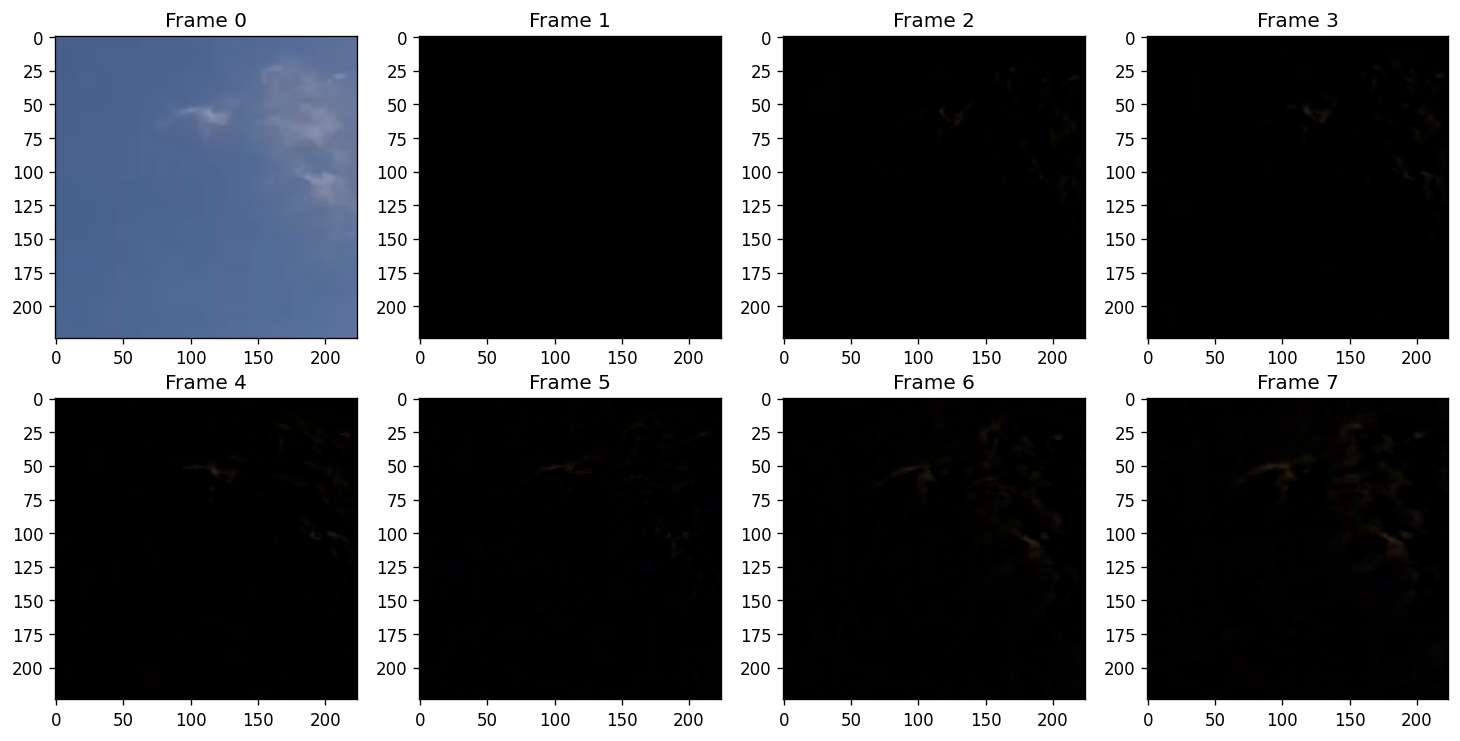

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

fig = plt.figure(figsize=(15, 15))


for frame_id in range(gop.length):
    fig.add_subplot(gop.length//2, gop.length//2, frame_id + 1)
    plt.imshow(gop.get_rgb_frame(frame_id))
    plt.title('Frame {}'.format(frame_id))

### Network

JAN INPUT SIZE = embed_dim = 4 * 8 + 5 = 37
num_heads = HAN_N_HEADS

In [6]:
from packages.network import H4vdmNet

net = H4vdmNet()

net.forward(gop, debug=True)

head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 32, embed_dim: 256, num_heads: 8
head_dim: 16, embed_dim: 64, num_heads: 4
head_dim: 16, embed_dim: 64, num_heads: 4
head_dim: 16, embed_dim: 64, num_heads: 4
head_dim: 16, embed_dim: 64, num_heads: 4
head_dim: 16, embed_dim: 64, num_heads: 4
head_dim: 16, embed_dim: 64, num_heads: 4
head_dim: 16, embed_dim: 64, num_heads: 4
head_dim: 16, embe

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not list